# GradCAM Example Notebook
## "Explain Me This: Salience-Based Explainability for Synthetic Face Detection Models"
### by Colton R. Crum, 1/31/23

In [72]:
# Import Libraries
from configparser import Interpolation
import numpy as np
import os
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import glob
import csv
import argparse
from tqdm import tqdm
#from xception.network.models import model_selection
import torchvision.transforms as transforms
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import GradCAM
from torchcam.methods import GradCAMpp
from torchcam.utils import overlay_mask
import torchvision
import pandas as pd
from sklearn.utils import resample
from mpl_toolkits.axes_grid1 import ImageGrid

## Necessary Arguments

In [84]:
parser = argparse.ArgumentParser()
# dummy argument to work in Jupyter Notebook instead of command line
parser.add_argument('-f')
parser.add_argument('-imgf','--imageFolder', default="../../Data/images/ffhq_aligned/00001.png", type=str)
parser.add_argument('-mp', '--modelPath', default="../../Models/weights/Densenet/densenet_cyborg_1/Logs/final_model.pth", type=str)
parser.add_argument('-n','--network', default="densenet", type=str)
parser.add_argument('-gt', '--gradcamType', default="gradcam", type=str)
parser.add_argument('-s', '--size', default="upscaled", type=str)

args = vars(parser.parse_args())

In [85]:
device = torch.device('cpu')

## Loading in the model

In [86]:
# Loading in the weights
weights = torch.load(args['modelPath'], map_location=device)

# Load weights of single binary DesNet121 model
if args['network'] == "resnet":
    im_size = 224
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
elif args['network'] == "inception":
    im_size = 299
    model = models.inception_v3(pretrained=True,aux_logits=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
elif args['network'] == "xception":
    im_size = 299
    model, *_ = model_selection(modelname='xception', num_out_classes=2)
else: # else DenseNet
    im_size = 224
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 2)

target_layers = [model.features[-1]]
# Loading the weights
model.load_state_dict(weights['state_dict'])
model = model.to(device)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Preprocessing

In [87]:
# Network
if args['network'] == "xception":
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize([0.5]*3, [0.5]*3)
            ])
else:
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

imagesScores=[]
sigmoid = nn.Sigmoid()

## Creating GradCAM

In [88]:
# Loading in the image
image = Image.open(img_path).convert('RGB')

# Image transformation
input_tensor = transform(image)
image.close()

# Generating the Grad-Cam
if args['gradcamType'] == "gradcam":
    #cam_extractor = GradCAM(model, target_layers)
    cam_extractor = GradCAM(model)
elif args['gradcamType'] == "gradcamPP":
    cam_extractor = GradCAMpp(model, target_layers)

## Processing GradCAM

In [89]:
# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

cam = to_pil_image(activation_map[0].squeeze(0)).convert('RGB')
cam = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.50)
if args['size'] == 'upscaled':
    cam = cam.resize((im_size, im_size), resample = Image.BICUBIC)

#cam.save("densenet-GradCAM-example.png")

## Display GradCAM

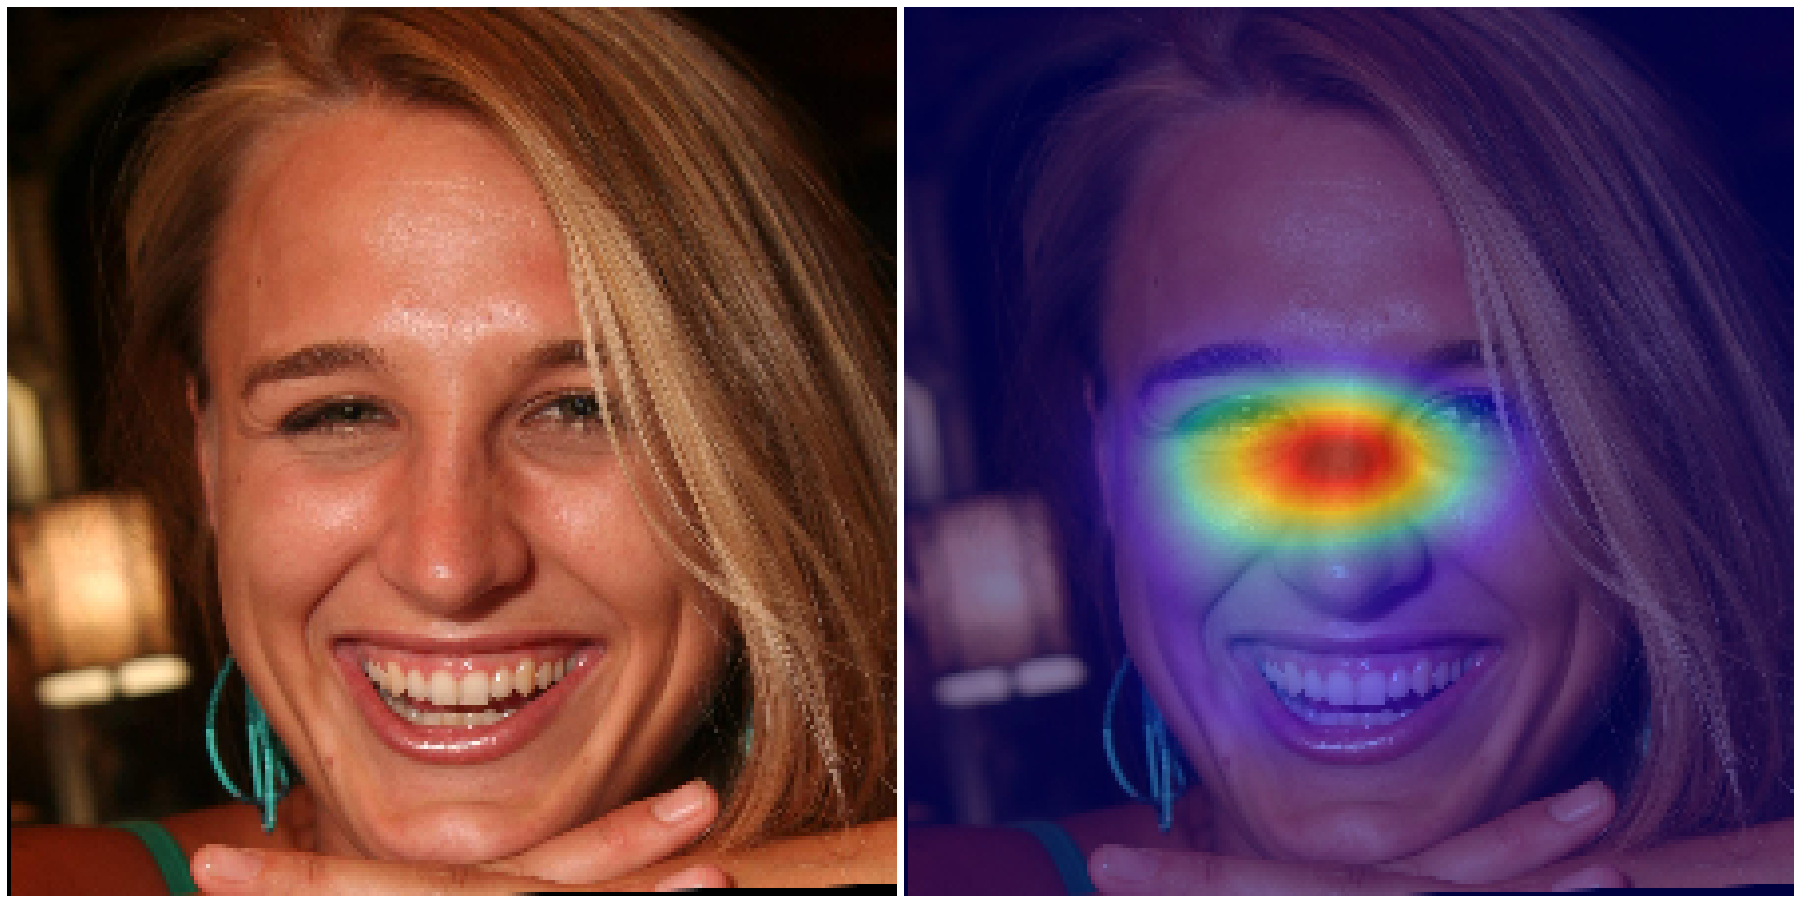

In [90]:
# originals
original_image = Image.open(args['imageFolder']).convert('RGB')
overlayed_cam = cam

fig = plt.figure(figsize=(10., 8.), facecolor='white')
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 aspect=1.2
                 )
for index, (ax, im) in enumerate(zip(grid, [im1, im2])):
    # Iterating over the grid returns the Axes.
    ax.axis('off')
    ax.grid(b=None)
    ax.imshow(im)
    #ax.set_title(predictions[index], fontsize=45)
fig.set_size_inches(32, 18)
#plt.savefig("entropy-densenet-example.png", format='png', bbox_inches='tight', dpi = 500)
plt.show()